<a href="https://colab.research.google.com/github/elsaflts/Laser-beam-propagation-from-a-laser-pointer-to-the-moon-/blob/main/FFT_numerical_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Split-step FFT Numerical method**
We first implement the split-step FFT algorithm in physical space. We wish to implement it using cartesian coordiantes using the *paraxial propagation equation* for the envelope of the laser beam $\tilde{E}$
\begin{equation}
\frac{\partial E}{\partial z} = \frac{i}{2k_0} \nabla^2_{\tilde{\perp}} E,
\end{equation}
where $\nabla_{\perp} \equiv \partial^2_{\tilde{x}} + \partial^2_{\tilde{y}}$.

# Test 1: large waist and long distance

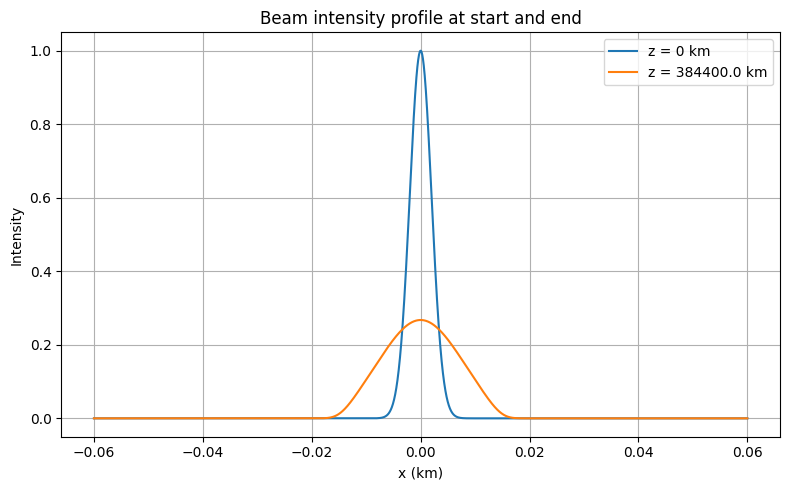

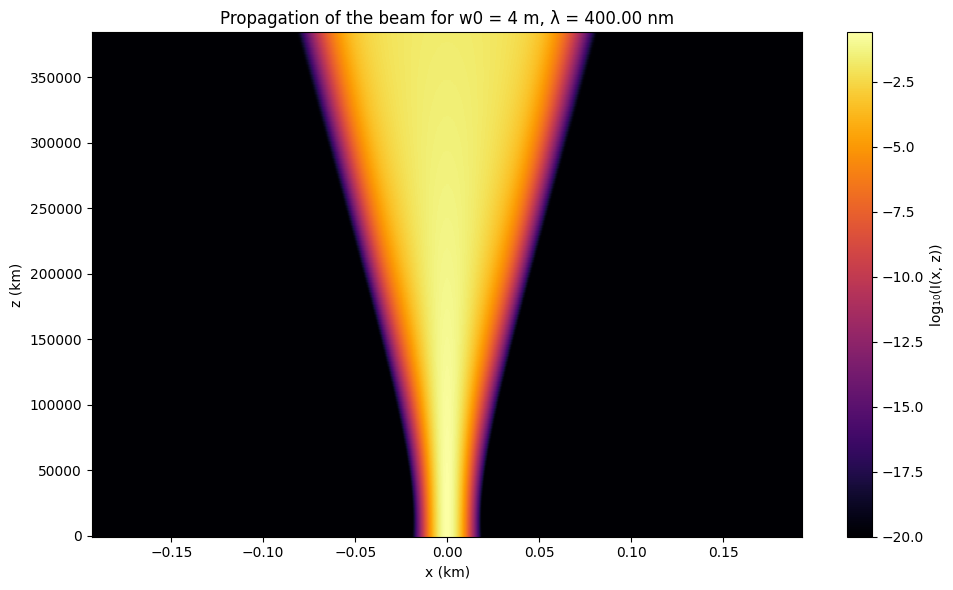

125663706.14359173


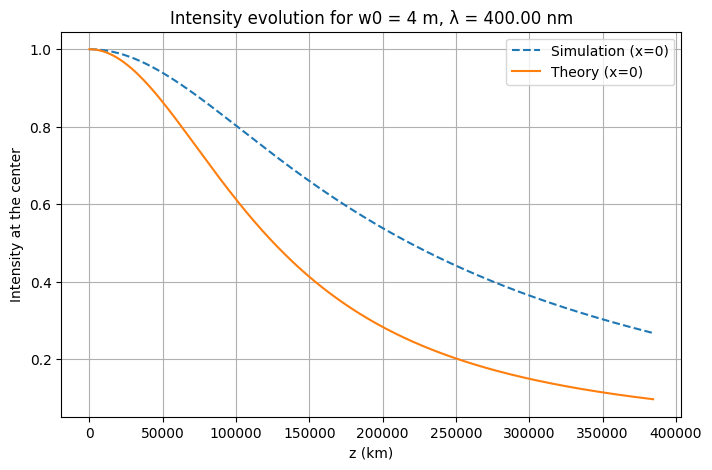

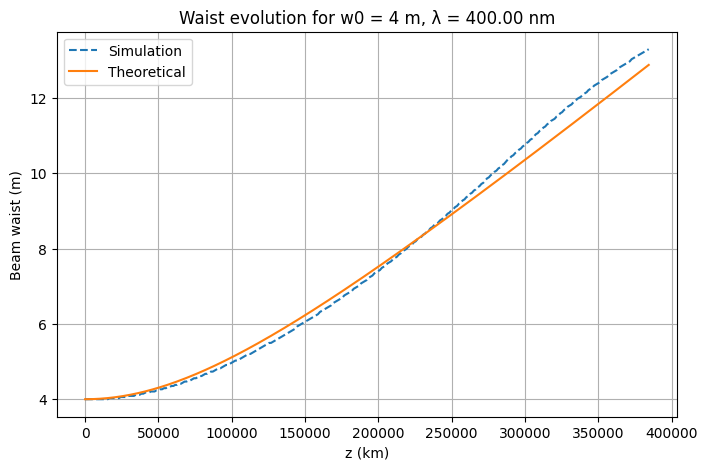

w(z_max) ≈ 42.77 m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters --------------------------------------------------------
λ = 400e-9                     # wavelength (m)
k0 = 2 * np.pi / λ             # wave number
w0 = 4                         # beam waist (m)


# Computational grid in normalised xi ----------------------------------------
xi_max = 15.0                  # increase the size of the window = enlarge boundaries
Nx = 2**12                     # number of discretization points

xi = np.linspace(-xi_max, xi_max, Nx) # creation of the grid
dxi = xi[1] - xi[0]
attenuation_mask = np.exp(- (xi / xi_max)**8)
x = xi * w0 # physical coordinate

# Initialisation of the beam -------------------------------------------------
C0 = np.exp(-xi**2)

# Propagation parameters -----------------------------------------------------
z_max = 3.844e8               # max distance (m)
dz = 1e3                      # propagation steps (m)
Nz = int(z_max / dz) + 1      # number of steps in z
# index of profile saving
n_snap = 300                  # number of profiles saved
save_step = Nz // n_snap
save_indices = set(list(range(0, Nz, save_step)) + [Nz-1])

# initialize list with z corresponding to the snapshot are stored
z_saved = []
C_z = []                      # storage of profiles

# normalisation in z direction by change of variable
zR = np.pi * w0**2 / λ
zeta_max = np.arctan(z_max /zR)
dzeta = zeta_max / Nz


# Split step operator --------------------------------------------------------
# diffraction operator (Fourier space)
k_xi = 2 * np.pi * np.fft.fftfreq(Nx, d=dxi)
H_half = np.exp(1j * (k_xi**2) * dzeta/4)

# potential operator (real space)
V_xi = 1 - xi**2
P_half = np.exp( 1j * V_xi * dzeta/2 )


# Split step Fourier loop -----------------------------------------------------
C = C0.copy()
for n in range(Nz):
    # storage
    if n in save_indices:
        C_z.append(C.copy())
        z_saved.append(n * dz)

    # half step diffusion
    C_hat = np.fft.fft(C)
    C_hat *= H_half
    C = np.fft.ifft(C_hat)

    # potential full step
    C *= P_half

    # half step diffusion
    C_hat = np.fft.fft(C)
    C_hat *= H_half
    C = np.fft.ifft(C_hat)
    # check progress :
    # if n % dz == 0:
      # print(f"[{n}/ {Nz}] z = {n*dz/1e3:.1f} km")

    C *= attenuation_mask

# conversion into tables
C_z = np.array(C_z)           # matrix, shape : (Nz_saved, Nx)
z_saved = np.array(z_saved)

# simulated intensity (not normalized)
intensity_sim = np.abs(C_z)**2

# Plot intensity profile at start and end ------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(x / 1e3, intensity_sim[0], label='z = 0 km')
plt.plot(x / 1e3, intensity_sim[-1], label=f'z = {z_saved[-1]/1e3:.1f} km')
plt.xlabel('x (km)')
plt.ylabel('Intensity')
plt.title('Beam intensity profile at start and end')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Visualisation of the propagation in physical space (x, z) ------------------
zR = np.pi * w0**2 / λ         # Rayleigh range

# preparation of axis
Nx = len(xi)
Nz = len(z_saved)

x_physical = np.zeros((Nz, Nx))          # grid x(z)
intensity_physical = np.zeros((Nz, Nx))  # intensity in physical space
x_max = 200

for i, z_val in enumerate(z_saved):
    wz = w0 * np.sqrt(1 + (z_val / zR)**2)       # width of the beam
    x_vals = xi * wz                             # transformation ξ -> x
    I_vals = (np.abs(C_z[i])**2) / wz            # normalisation of intensity

    x_physical[i, :] = x_vals
    intensity_physical[i, :] = I_vals            # gives |E|^2


# interpolation grid
x_uniform = np.linspace(np.min(x_physical), np.max(x_physical), Nx)
X_grid, Z_grid = np.meshgrid(x_uniform, z_saved)

# meshing
I_grid = np.zeros_like(X_grid)

for i in range(Nz):
    I_grid[i, :] = np.interp(x_uniform, x_physical[i, :], intensity_physical[i, :], left=0, right=0)

# plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(X_grid / 1e3, Z_grid / 1e3, np.log10(I_grid + 1e-20), shading='auto', cmap='inferno')
plt.colorbar(label='log₁₀(I(x, z))')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.title(f'Propagation of the beam for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.tight_layout()
plt.show()

zRR = 3*zR
print(zR)

# Test 1 : intensity comparison with theory at x=0 ---------------------------
ix0 = np.argmin(np.abs(x))              # find index x=0 (the closest)
I_sim_centre = intensity_sim[:, ix0]    # column along x=0

# theoretical intensity at the center (x=0) : (w0 / w(z))^2
zR = np.pi * w0**2 / λ
wz = w0 * np.sqrt(1 + (z_saved / zR)**2)
I_th_centre = (w0 / wz)**2

plt.figure(figsize=(8,5))
plt.plot(z_saved/1e3, I_sim_centre, '--', label='Simulation (x=0)')
plt.plot(z_saved/1e3, I_th_centre, label='Theory (x=0)')
plt.xlabel('z (km)')
plt.ylabel('Intensity at the center')
plt.title(f'Intensity evolution for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.legend()
plt.grid(True)
plt.show()


# Test 2 : comparison of the waist evolution with theory ---------------------
thresh = 1/np.e**2
w_sim = []
for I in intensity_sim:
    Imax = I.max()
    mask = I >= Imax*thresh
    xs = x[mask]
    w_sim.append((xs.max() - xs.min())/2)
w_sim = np.array(w_sim)

plt.figure(figsize=(8,5))
plt.plot(z_saved/1e3, w_sim, '--', label='Simulation')
plt.plot(z_saved/1e3, wz, label='Theoretical')
plt.xlabel('z (km)')
plt.ylabel('Beam waist (m)')
plt.title(f'Waist evolution for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.legend()
plt.grid(True)
plt.show()


# Test 3 : final beam width --------------------------------------------------

# last simualted intensity and x associated
I_final = intensity_physical[-1]   # last line
x_final = x_physical[-1]

# 1/e² criteria
Imax = I_final.max()
threshold = 1 / np.e**2
mask = I_final >= Imax * threshold

# waist at z_max
if np.any(mask):
    w_final = (x_final[mask].max() - x_final[mask].min()) / 2
else:
    w_final = np.nan

print(f"w(z_max) ≈ {w_final:.2f} m")

# Test 4 : relative error ----------------------------------------------------
z_km = z_saved / 1e3

# compute relative errors (%)
relI = np.abs(I_sim_centre - I_th_centre) / I_th_centre * 100
relw = np.abs(np.array(w_sim)   - wz)        / wz         * 100

plt.figure(figsize=(8,6))
plt.plot(z_km, relI, label='On-axis intensity')
plt.plot(z_km, relw, label='Beam waist',   linestyle='--')
plt.xlabel('Propagation distance $z$ (km)')
plt.ylabel('Relative error (%)')
plt.title('Relative error of simulation vs. theory')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Test 2: narrow waist and short distance


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters --------------------------------------------------------
λ = 400e-9                     # wavelength (m)
k0 = 2 * np.pi / λ             # wave number
w0 = 1e-1                      # beam waist (m)


# Computational grid in normalised xi ----------------------------------------
xi_max = 15.0                  # increase the size of the window = enlarge boundaries
Nx = 2**12                     # number of discretization points

xi = np.linspace(-xi_max, xi_max, Nx) # creation of the grid
dxi = xi[1] - xi[0]
attenuation_mask = np.exp(- (xi / xi_max)**8)
x = xi * w0 # physical coordinate

# Initialisation of the beam -------------------------------------------------
C0 = np.exp(-xi**2)

# Propagation parameters -----------------------------------------------------
z_max = 300e3               # max distance (m)
dz = 1e2                      # propagation steps (m)
Nz = int(z_max / dz) + 1      # number of steps in z
# index of profile saving
n_snap = 300                  # number of profiles saved
save_step = Nz // n_snap
save_indices = set(list(range(0, Nz, save_step)) + [Nz-1])

# initialize list with z corresponding to the snapshot are stored
z_saved = []
C_z = []                      # storage of profiles

# normalisation in z direction by change of variable
zR = np.pi * w0**2 / λ
zeta_max = np.arctan(z_max /zR)
dzeta = zeta_max / Nz


# Split step operator --------------------------------------------------------
# diffraction operator (Fourier space)
k_xi = 2 * np.pi * np.fft.fftfreq(Nx, d=dxi)
H_half = np.exp(1j * (k_xi**2) * dzeta/4)

# potential operator (real space)
V_xi = 1 - xi**2
P_half = np.exp( 1j * V_xi * dzeta/2 )


# Split step Fourier loop -----------------------------------------------------
C = C0.copy()
for n in range(Nz):
    # storage
    if n in save_indices:
        C_z.append(C.copy())
        z_saved.append(n * dz)

    # half step diffusion
    C_hat = np.fft.fft(C)
    C_hat *= H_half
    C = np.fft.ifft(C_hat)

    # potential full step
    C *= P_half

    # half step diffusion
    C_hat = np.fft.fft(C)
    C_hat *= H_half
    C = np.fft.ifft(C_hat)
    # check progress :
    # if n % dz == 0:
      # print(f"[{n}/ {Nz}] z = {n*dz/1e3:.1f} km")

    C *= attenuation_mask

# conversion into tables
C_z = np.array(C_z)           # matrix, shape : (Nz_saved, Nx)
z_saved = np.array(z_saved)

# simulated intensity (not normalized)
intensity_sim = np.abs(C_z)**2

# Plot intensity profile at start and end ------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(x / 1e3, intensity_sim[0], label='z = 0 km')
plt.plot(x / 1e3, intensity_sim[-1], label=f'z = {z_saved[-1]/1e3:.1f} km')
plt.xlabel('x (km)')
plt.ylabel('Intensity')
plt.title('Beam intensity profile at start and end')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Visualisation of the propagation in physical space (x, z) ------------------
zR = np.pi * w0**2 / λ         # Rayleigh range

# preparation of axis
Nx = len(xi)
Nz = len(z_saved)

x_physical = np.zeros((Nz, Nx))          # grid x(z)
intensity_physical = np.zeros((Nz, Nx))  # intensity in physical space
x_max = 200

for i, z_val in enumerate(z_saved):
    wz = w0 * np.sqrt(1 + (z_val / zR)**2)       # width of the beam
    x_vals = xi * wz                             # transformation ξ -> x
    I_vals = (np.abs(C_z[i])**2) / wz            # normalisation of intensity

    x_physical[i, :] = x_vals
    intensity_physical[i, :] = I_vals            # gives |E|^2


# interpolation grid
x_uniform = np.linspace(np.min(x_physical), np.max(x_physical), Nx)
X_grid, Z_grid = np.meshgrid(x_uniform, z_saved)

# meshing
I_grid = np.zeros_like(X_grid)

for i in range(Nz):
    I_grid[i, :] = np.interp(x_uniform, x_physical[i, :], intensity_physical[i, :], left=0, right=0)

# plot
plt.figure(figsize=(10, 6))
plt.pcolormesh(X_grid / 1e3, Z_grid / 1e3, np.log10(I_grid + 1e-20), shading='auto', cmap='inferno')
plt.colorbar(label='log₁₀(I(x, z))')
plt.xlabel('x (km)')
plt.ylabel('z (km)')
plt.title(f'Propagation of the beam for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.tight_layout()
plt.show()

zRR = 3*zR
print(zR)

# Test 1 : intensity comparison with theory at x=0 ---------------------------
ix0 = np.argmin(np.abs(x))              # find index x=0 (the closest)
I_sim_centre = intensity_sim[:, ix0]    # column along x=0

# theoretical intensity at the center (x=0) : (w0 / w(z))^2
zR = np.pi * w0**2 / λ
wz = w0 * np.sqrt(1 + (z_saved / zR)**2)
I_th_centre = (w0 / wz)**2

plt.figure(figsize=(8,5))
plt.plot(z_saved/1e3, I_sim_centre, '--', label='Simulation (x=0)')
plt.plot(z_saved/1e3, I_th_centre, label='Theory (x=0)')
plt.xlabel('z (km)')
plt.ylabel('Intensity at the center')
plt.title(f'Intensity evolution for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.legend()
plt.grid(True)
plt.show()


# Test 2 : comparison of the waist evolution with theory ---------------------
thresh = 1/np.e**2
w_sim = []
for I in intensity_sim:
    Imax = I.max()
    mask = I >= Imax*thresh
    xs = x[mask]
    w_sim.append((xs.max() - xs.min())/2)
w_sim = np.array(w_sim)

plt.figure(figsize=(8,5))
plt.plot(z_saved/1e3, w_sim, '--', label='Simulation')
plt.plot(z_saved/1e3, wz, label='Theoretical')
plt.xlabel('z (km)')
plt.ylabel('Beam waist (m)')
plt.title(f'Waist evolution for w0 = {w0} m, λ = {λ * 1e9:.2f} nm')
plt.legend()
plt.grid(True)
plt.show()


# Test 3 : final beam width --------------------------------------------------

# last simualted intensity and x associated
I_final = intensity_physical[-1]   # last line
x_final = x_physical[-1]

# 1/e² criteria
Imax = I_final.max()
threshold = 1 / np.e**2
mask = I_final >= Imax * threshold

# waist at z_max
if np.any(mask):
    w_final = (x_final[mask].max() - x_final[mask].min()) / 2
else:
    w_final = np.nan

print(f"w(z_max) ≈ {w_final:.2f} m")
